In [1]:
import os
import clr
import sys
from imp import reload
from System import Array
from time import sleep, time
import numpy as np
from matplotlib import pyplot as plt
import peakutils
# sys.path.append(os.getcwd())
%matplotlib inline

import qcodes as qc
qc.show_subprocess_widget()

import qcodes.instrument.parameter as parameter

loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

<IPython.core.display.Javascript object>

In [2]:
dummy = parameter.ManualParameter(name="dummy")

def try_close_instruments(instruments=['PulseBlaster', 'ArbStudio', 'SIM900', 'ATS', 'ATS_controller']):
    if isinstance(instruments, str):
        instruments = [instruments]
    for instrument in instruments:
        try:
            eval('{}.close()'.format(instrument_name))
        except:
            pass
        
def configure_PulsBlaster(PulseBlaster, repetition_rate, marker_cycles=100, sampling_rate=500):
    cycles = sampling_rate*1e6 * repetition_rate

    PulseBlaster.detect_boards()
    PulseBlaster.select_board(0)
    PulseBlaster.core_clock(sampling_rate)

    PulseBlaster.start_programming()
    start = PulseBlaster.send_instruction(1,'continue',0,marker_cycles)
    PulseBlaster.send_instruction(0, 'branch', start, cycles - marker_cycles)
    PulseBlaster.stop_programming()
    
def configure_ArbStudio(ArbStudio, repetition_rate, marker_cycles=100):
    ArbStudio.ch3_trigger_mode('stepped')
    ArbStudio.ch3_trigger_source('fp_trigger_in')

    # Add waveforms
    ArbStudio.ch3_clear_waveforms()
    ArbStudio.ch3_add_waveform([1]*marker_cycles + [0,0])

    #Add sequence
    ArbStudio.ch3_sequence([0])

    #Load waveforms and sequence
    waveforms = ArbStudio.load_waveforms()
    sequences = ArbStudio.load_sequence()

In [20]:
import qcodes.instrument_drivers.spincore.PulseBlasterESRPRO as PulseBlaster_driver
import qcodes.instrument_drivers.lecroy.ArbStudio1104 as ArbStudio_driver
import qcodes.instrument_drivers.stanford_research.SIM900 as SIM900_driver
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_controller_driver

for instrument_name in ['PulseBlaster', 'ArbStudio', 'SIM900', 'ATS', 'ATS_controller']:
    try_close_instruments(instrument_name)
    eval('reload({}_driver)'.format(instrument_name))

PulseBlaster = PulseBlaster_driver.PulseBlaster('PulseBlaster')

dll_path = os.path.join(os.getcwd(),'lecroy_driver\\Library\\ArbStudioSDK.dll')
ArbStudio = ArbStudio_driver.ArbStudio1104('ArbStudio', dll_path, server_name=None)

SIM900 = SIM900_driver.SIM900('SIM900', 'GPIB0::4::INSTR')
TG, LB, RB, TGAC, SRC, _, DS, DF = [eval('SIM900.chan{}'.format(i)) for i in range(1,9)]

ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_controller_driver.Average_AcquisitionController(name='ATS_control', 
                                                           alazar_name='ATS',
                                                           server_name='Alazar_server')
# Configure ATS and ATS_controller
ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=135,
           channel_range=2,
           sample_rate=1e6,
           coupling='DC')

In [8]:
repetition_rate = 0.01

configure_PulsBlaster(PulseBlaster, repetition_rate)
configure_ArbStudio(ArbStudio, repetition_rate)
ATS_controller.average_mode('point')
samples_per_record = int(16 * round(float(ATS.sample_rate()*repetition_rate*0.7)/16))
ATS_controller.set_acquisitionkwargs(buffer_timeout=5000,
                                     samples_per_record=samples_per_record,
                                     records_per_buffer=1,
                                     buffers_per_acquisition=1,
                                     channel_selection='A')

NameError: name 'PulseBlaster' is not defined

In [8]:
ArbStudio.stop()
PulseBlaster.stop()

qc.halt_bg()

No loop running


In [9]:
ArbStudio.run([3])
PulseBlaster.start()
data = qc.Loop(TGAC[1:2:0.01], delay=0.001).loop(DS[2:3:0.01]).each(qc.Task(DF,DS),
    ATS_controller.acquisition).run(name='testsweep', progress_interval=True)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = 'data/2016-08-20/#070_testsweep_17-04-14'
   <Type>   | <array_id>                   | <array.name>     | <array.shape>
   Setpoint | SIM900_chan4_set             | chan4            | (100,)
   Setpoint | SIM900_chan7_set             | chan7            | (100, 100)
   Measured | ATS_control_Channel_A_signal | Channel_A_signal | (100, 100)
started at 2016-08-20 17:04:14


In [ ]:
data = qc.Loop(dummy(1:, delay=0.01).each(
    ATS_controller.acquisition).run(name='testsweep', progress_interval=True)

# Single shots

In [3]:
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_controller_driver

for instrument_name in ['ATS', 'ATS_controller']:
    try_close_instruments(instrument_name)
    eval('reload({}_driver)'.format(instrument_name))
ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_controller_driver.Average_AcquisitionController(name='ATS_control', 
                                                           alazar_name='ATS',
                                                           server_name='Alazar_server')
# Configure ATS and ATS_controller
ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=135,
           channel_range=2,
           sample_rate=1e6,
           coupling='DC')

load_duration = 5 # ms
read_duration = 20 # ms
empty_duration = 5 # ms

load_pts = round(load_duration/1e3*ATS.sample_rate())
read_pts = round(read_duration/1e3*ATS.sample_rate())
empty_pts = round(empty_duration/1e3*ATS.sample_rate())

Wall time: 2.5 s


<IPython.core.display.Javascript object>


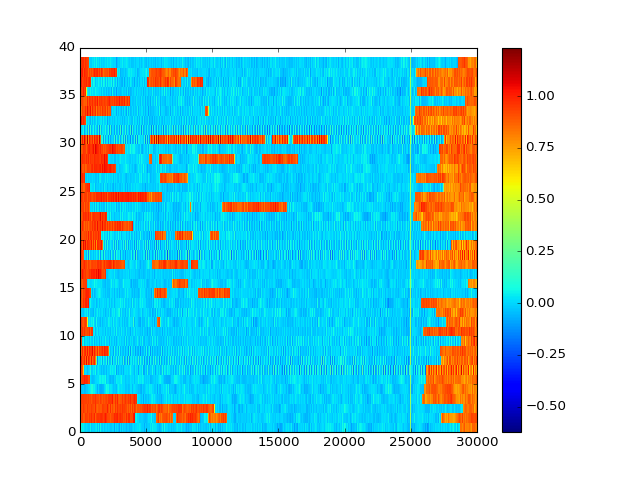

<IPython.core.display.Javascript object>


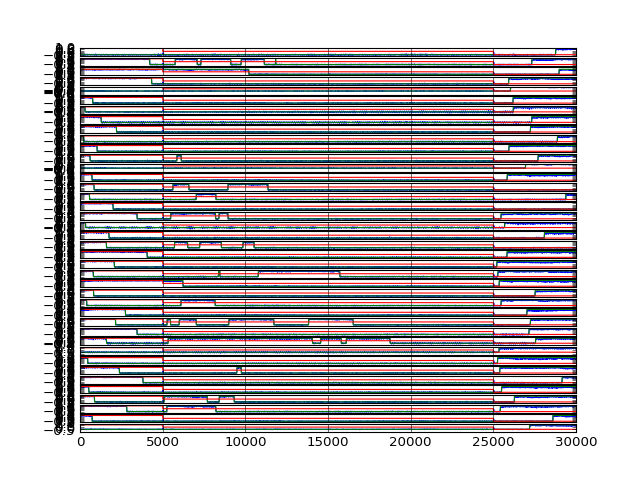

In [99]:
read_length=0.03

ATS_controller.average_mode('none')
samples_per_record = int(16 * round(float(ATS.sample_rate()*read_length)/16))
ATS_controller.set_acquisitionkwargs(buffer_timeout=5000,
                                     samples_per_record=samples_per_record,
                                     records_per_buffer=1,
                                     buffers_per_acquisition=40,
                                     channel_selection='AC')
%time data, data_awg = ATS_controller.acquisition()
plt.figure()
plt.pcolormesh(range(samples_per_record), 
             range(np.shape(data)[0]), data)
plt.xlim([0,samples_per_record])
plt.colorbar()
    
fig, axes = plt.subplots(len(data), sharex=True)
for k, trace in enumerate(data):
    axes[k].plot(trace)
    axes[k].plot(trace > 0.5)
    axes[k].plot([1]*load_pts+[0.5]*read_pts+[0]*empty_pts)

## Analysis

In [98]:
import lmfit

In [100]:
load_data = data[:,:load_pts]
read_data = data[:,load_pts:load_pts+read_pts]
empty_data = data[:,load_pts+read_pts:]

In [171]:
def find_high_low(data):
    hist, bin_edges = np.histogram(np.ravel(data), bins=30)
    peaks_idx = np.sort(peakutils.indexes(hist, thres=0.02,min_dist = 5))
    assert len(peaks_idx)==2, 'Found {} peaks instead of two'.format(len(peaks_idx))
    
    #Find threshold, mean low, and mean high voltages
    threshold_idx = int(round(np.mean(peaks_idx)))
    threshold_voltage = bin_edges[threshold_idx]

    # Create dictionaries containing information about the low, high state
    low, high = {},{}
    low['data'] = data[data < threshold_voltage]
    high['data'] = data[data > threshold_voltage]
    for signal in [low, high]:
        signal['mean'] = np.mean(signal['data'])
        signal['std'] = np.std(signal['data'])
    SNR = (high['mean'] - low['mean'])/np.sqrt(high['std']**2 + low['std']**2)
    assert SNR > 3, 'Signal to noise ratio {} is too low'.format(SNR)
    # Plotting
    plt.figure()
#     plt.bar(bin_edges[:-1], hist,width=0.05)
    for k, signal in enumerate([low, high]):
        sub_hist, sub_bin_edges = np.histogram(np.ravel(signal['data']), bins=10)
        plt.bar(sub_bin_edges[:-1], sub_hist, width=0.05, color='bg'[k])
        plt.plot(signal['mean'], 100, 'or', ms=12)
        
    plt.plot(bin_edges[:-1][peaks_idx], hist[peaks_idx], 'or', ms=12)
    
    return low, high

11.2104820667


<IPython.core.display.Javascript object>


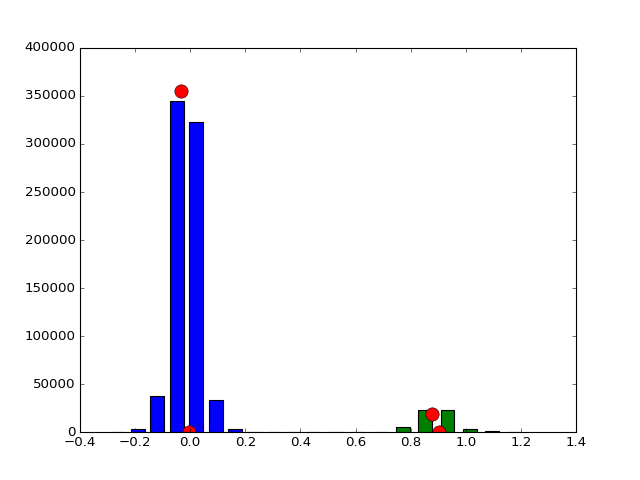

({'data': array([-0.02270508, -0.02563477, -0.03125   , ...,  0.01464844,
          0.01000977,  0.00366211]),
  'mean': -0.0050721048903801056,
  'std': 0.045694098151364174},
 {'data': array([ 0.4453125 ,  0.50927734,  0.57006836, ...,  0.56494141,
          0.51074219,  0.45532227]),
  'mean': 0.90432526354805265,
  'std': 0.067026473316320903})

In [173]:
find_high_low(read_data)